![Py4Eng](img/logo.png)

# Cython: type annotation and C interface
## Yoav Ram

[Cython](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance) is a compiler that compiles Python-like code files to C code. Still, ‘’Cython is not a Python to C translator’‘: Cython does not take your Python program and “turns it into C”. 
Rather, the result makes full use of the Python runtime environment.
Your code is still in Python-it runs within the Python runtime environment-but rather than compiling to interpreted Python bytecode, it is compiled to native machine code, with the addition of extra syntax for easy embedding of faster C-like code.

Cython has two important consequences:

- **Speed.** How much depends very much on the program involved though. Typical Python numerical programs would tend to gain very little as most time is spent in lower-level C that is used in a high-level fashion. However for-loop-style programs can gain many orders of magnitude, when typing information is added (and is so made possible as a realistic alternative).
- **Easy calling into C code.** One of Cython’s purposes is to allow easy wrapping of C libraries. When writing code in Cython you can call into C code as easily as into Python code.

Some Python constructs are not yet supported, though making Cython compile all Python code is a stated goal (among the more important omissions are inner functions and generator functions).

# Hello world!

Let's start with a simple *Hello World!* to check that everything is working.

We load the `Cython` magic that will allow us to quickly use Cython inside the notebook.
The magic is installed with the `cython` package (`mamba install cython`, `conda install cython` or `pip install cython`).

Cython requires that a C compiler is installed and can be found, and on **Windows** that may be tricky, here are some resources:
- [Install Cython on Windows](https://github.com/cython/cython/wiki/InstallingOnWindows)
- [Install C compiler on Windows](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows)
- [Compiling Python extensions on Windows](https://blog.ionelmc.ro/2014/12/21/compiling-python-extensions-on-windows/)

On **Linux/MacOS** you probably already have a compiler, check with `!clang --version` or `!gcc --version`. 
You can install `gcc`:
- On [Ubuntu](https://help.ubuntu.com/community/InstallingCompilers) you should run `sudo apt-get install build-essential`.
- On CentOS you just need to install development tools: `sudo yum group install "Development Tools"`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import Cython
print("Cython", Cython.__version__)

%load_ext Cython

Cython 3.0.12


In [2]:
%%cython 
print("Hello World!")

Hello World!


# First Cython example

Let's see a quick example of what Cython can do for us. 

Consider the following Python function that returns the first k prime numbers (but not more than 1000):

In [54]:
def find_k_primes(k):
    primes = [None] * 1000 # pre-allocate so we don't use append
    n_primes = 0  # count number of primes
    candidate = 2 
    while n_primes < min(k, 1000):
        # is candidate a prime number?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a new prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return primes[:n_primes] # only return the primes

In [4]:
assert find_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Here is the Cython version of this function; the only addition here is that we use `cdef` to define the types of all local variabes. This `cdef` statement is used to define **local C variables**. We also add `int` in the arguments list to define the type of `k`; this means that any object passed will be **converted to a C integer**.

In [5]:
%%cython
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0 
    candidate = 2
    while n_primes < min(k, 1000):
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break 
        else: 
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return [p for p in primes[:n_primes]] # convert primes from a cython type to a python list

In [6]:
find_k_primes(100) == cfind_k_primes(100)

True

In [7]:
n = 1000
%timeit find_k_primes(n)
%timeit cfind_k_primes(n)

33.5 ms ± 85.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.25 ms ± 443 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Note that in the inner loop we only refer variables with type definitions, and thus C objects. 
Therefore, the loop is translated to a C loop by Cython and runs very fast.

# Creating a Cython module

We can now put that Cython code into a separate file with extension `pyx`. 

In [8]:
!mkdir ../scripts/cython
%cd ../scripts/cython

/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython


In [9]:
%pwd

'/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython'

In [10]:
%%file primes.pyx
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  
    candidate = 2
    while n_primes < min(k, 1000):
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break 
        else:
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return [p for p in primes[:n_primes]] # convert primes from a cython type to a python list

Writing primes.pyx


Now we compile it and import it with a single stroke using the [`pyximport` module](http://docs.cython.org/en/stable/src/reference/compilation.html),

> Cython code, unlike Python, must be compiled.
> This happens in two stages:
> A .pyx file is compiles by Cython to a .c file.
> The .c file is compiled by a C comiler to a .so file (or a .pyd file on Windows)

In [11]:
import pyximport
pyximport.install(language_level=3)

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x10cc85250>)

In [12]:
%pwd

'/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython'

In [13]:
from primes import cfind_k_primes

In [14]:
assert cfind_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

You can also do this on your own, without `pyximport`. This is useful when shipping or if you just want to see the C file - for example, to see how much work Cython saved you from doing!

You start by writing a `setup.py` file which imports `cythonize` from the Cython package and tells `setup` (the standard way to setup Python packages, using `distutils` or `setuptools`) to build an extension module using `cythonize`.

In [15]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("primes.pyx")
)

Writing setup.py


Run it with this command, which builds the extension:

In [16]:
python = os.path.join(sys.base_prefix, 'bin', 'python')
!$python setup.py build_ext --inplace

Compiling primes.pyx because it changed.
[1/1] Cythonizing primes.pyx
/Users/yoavram/miniforge3/envs/DataSciPy/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/yoavram/Work/Teaching/Py4Eng/scripts/cython/primes.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Let's see what was generated (this might look different on different machines, especially Windows vs. Linux):

In [17]:
%ls

build/                        primes.pyx
primes.c                      setup.py
primes.cpython-312-darwin.so*


And the actual C file:

In [18]:
%less primes.c

/* Generated by Cython 3.0.12 */

/* BEGIN: Cython Metadata
{
    "distutils": {
        "name": "primes",
        "sources": [
            "primes.pyx"
        ]
    },
    "module_name": "primes"
}
END: Cython Metadata */

#ifndef PY_SSIZE_T_CLEAN
#define PY_SSIZE_T_CLEAN
#endif /* PY_SSIZE_T_CLEAN */
#if defined(CYTHON_LIMITED_API) && 0
  #ifndef Py_LIMITED_API
    #if CYTHON_LIMITED_API+0 > 0x03030000
      #define Py_LIMITED_API CYTHON_LIMITED_API
    #else
      #define Py_LIMITED_API 0x03030000
    #endif
  #endif
#endif

#include "Python.h"
#ifndef Py_PYTHON_H
    #error Python headers needed to compile C extensions, please install development version of Python.
#elif PY_VERSION_HEX < 0x02070000 || (0x03000000 <= PY_VERSION_HEX && PY_VERSION_HEX < 0x03030000)
    #error Cython requires Python 2.7+ or Python 3.3+.
#else
#if defined(CYTHON_LIMITED_API) && CYTHON_LIMITED_API
#define __PYX_EXTRA_ABI_MODULE_NAME "limited"
#else
#define __PYX_EXTRA_ABI_MODULE_NAME ""
#endif
#define C

You can now import `primes` as if it was a regular Python module (if you aren't sure which of the things you are importing, restart your kernel, but don't forger to change directory to `../scripts/cython`).

Here's a small test script.

In [19]:
%%file test_primes.py
from primes import cfind_k_primes
assert cfind_k_primes(10) ==  [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Writing test_primes.py


In [20]:
%run test_primes.py

# Integration

This is from Robert Bradshaw's [SciPy 2008 slides](http://wiki.sagemath.org/scipy08?action=AttachFile&do=get&target=scipy-cython.tgz).

We will write a simple integration code to integrate $f(x) = x^3 - 3x$:

In [21]:
def f(x):
    return x**3 - 3 * x

def integrate_f(a , b , N):
    s = 0
    dx = (b - a )/ N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

integrate_f(0, 1, 100000)

-1.249989999975006

In [22]:
%timeit integrate_f(0, 1, 100000)

23.1 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now, the same with Cython. Note that when we define a function with `cdef` we can set a return value but we can only c
all it from within Cython. When we define a function with `def` we can import it and call it from Python.

Note that we change `x**3` to `x * x * x`.

In [23]:
%%cython
cdef double g(double x):
    return x * x * x - 3* x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a )/ N
    cdef int i
    for i in range(N):
        s += g( a + i * dx )
    return s * dx

In [24]:
integrate_g(0, 1, 100000)

-1.249989999975006

In [25]:
%timeit integrate_g(0, 1, 100000)

250 μs ± 1.83 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now let's integrate 
$$
\int_a^b{\frac{\sin{x}}{x}}
$$

Without Cython, we should use either `math.sin` or `numpy.sin`:

In [26]:
def f(x):
    return np.sin(x) / x

integrate_f(1, 2, 100000)

0.6593318405457452

With Cython, we can import some C functions using an `extern` block:

In [27]:
%%cython
cdef extern from "math.h":
    double sin(double)
    double cos(double)

cdef double g(double x):
    return sin(x)/x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a) /  N
    cdef int i
    for i in range(N):
        s += g(a + i * dx)
    return s * dx

In [28]:
integrate_g(1, 2, 100000)

0.6593318405457452

In [29]:
%timeit integrate_f(1, 3, 100000)
%timeit integrate_g(1, 3, 100000)

99.2 ms ± 509 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
899 μs ± 12.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Cython with NumPy

Cython works well with NumPy.

Let's loop over a NumPy array:

In [30]:
def summ(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s

In [32]:
%%cython
cimport numpy as np

def csumm(long[:] x): # input type is a buffer
    cdef int i = 0
    cdef long s = 0
    cdef Py_ssize_t size = x.shape[0]
    for i in range(size):
        s += x[i]
    return s

Content of stderr:
In file included from /Users/yoavram/.cache/ipython/cython/_cython_magic_e0d3338594ec9daa6e29b31a94eb2183be3e85f5.c:1251:
In file included from /Users/yoavram/miniforge3/envs/DataSciPy/lib/python3.12/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/yoavram/miniforge3/envs/DataSciPy/lib/python3.12/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/yoavram/miniforge3/envs/DataSciPy/lib/python3.12/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/yoavram/miniforge3/envs/DataSciPy/lib/python3.12/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^
/Users/yoavram/.cache/ipython/cython/_cython_magic_e0d3338594ec9daa6e29b31a94eb2183be3e85f5.c:23132:13: warning: cod

In [33]:
x = np.random.randint(0, 9, 100000)
summ(x), csumm(x)

(401960, 401960)

In [34]:
%timeit summ(x)
%timeit csumm(x)

13.7 ms ± 95.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.1 μs ± 686 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Note that if you would type `s` and `arr` as made of `int` you would get an error because Python's `int` is a C `long`... But you would get a `ValueError`, not a segmentation fault or anything like that. Here's an example:

In [40]:
y = np.array([0.1, 0.2, 0.3])
csumm(y)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

## Mandelbrot fractal

The following creates Mandelbrot's famous fractal.

In [50]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

CPU times: user 1.05 s, sys: 3.66 ms, total: 1.06 s
Wall time: 1.06 s


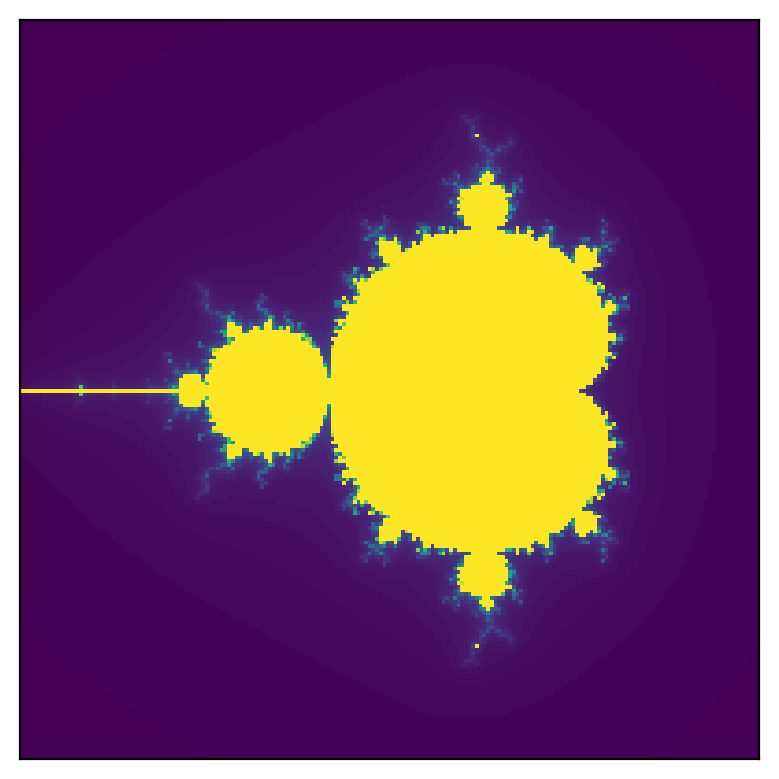

In [51]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)
%time mandelbrot(m, size, iterations)
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

It's a long computation with three nested loopes, let's see if Cython can make it better.
Here, we introduce type defs for everything we can, and we remove `np.abs` in favor of manual computation of the norm of `z` (and using `np` leads to a function that has the same runtime as the above Python version).

In [55]:
%%cython
def cmandelbrot(int[:,:] m, int size, int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real*z.real + z.imag*z.imag <= 100:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

Content of stderr:
/Users/yoavram/.cache/ipython/cython/_cython_magic_487f49118b2cfeccaf6f7aa324ebc0decabe8450.c:21447:13: warning: code will never be executed [-Wunreachable-code]
 21447 |             goto bad;
       |             ^~~~~~~~
/Users/yoavram/.cache/ipython/cython/_cython_magic_487f49118b2cfeccaf6f7aa324ebc0decabe8450.c:22126:26: warning: code will never be executed [-Wunreachable-code]
 22126 |                 module = PyImport_ImportModuleLevelObject(
       |                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 warnings generated.

In [56]:
%timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)

1.05 s ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.41 ms ± 132 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise: difference matrix

Write a Cython function that calculates the difference matrix for a given array.
Compare it to the NumPy implementation.

In [10]:
def diff_mat(x):
    return x.reshape(-1, 1) - x

In [95]:
x = np.random.random(10000)
assert np.allclose(diff_mat(x), cdiff_mat(x))
%timeit diff_mat(x)
%timeit cdiff_mat(x)

455 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
496 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You can explore other [compiler directives](https://github.com/cython/cython/wiki/enhancements-compilerdirectives) such as `wraparound` and `nonecheck`.

# Releasing the GIL

Cython can be directed to [release the GIL](http://docs.cython.org/src/userguide/external_C_code.html#acquiring-and-releasing-the-gil), thus enabling multiple threads to run in parallel (if the OS allows it) and achieve performence gain even in comparison to multi-processing, as threads are cheaper than processes and thread communication is faster than process communication.

In [5]:
import imageio
from skimage.transform import resize

def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [48]:
%cd ../../sessions

/Users/yoavram/Work/Teaching/Py4Eng/sessions


Let's do a segmentation demonstration.

(dtype('float64'), (900, 944), np.float64(0.0), np.float64(255.0))

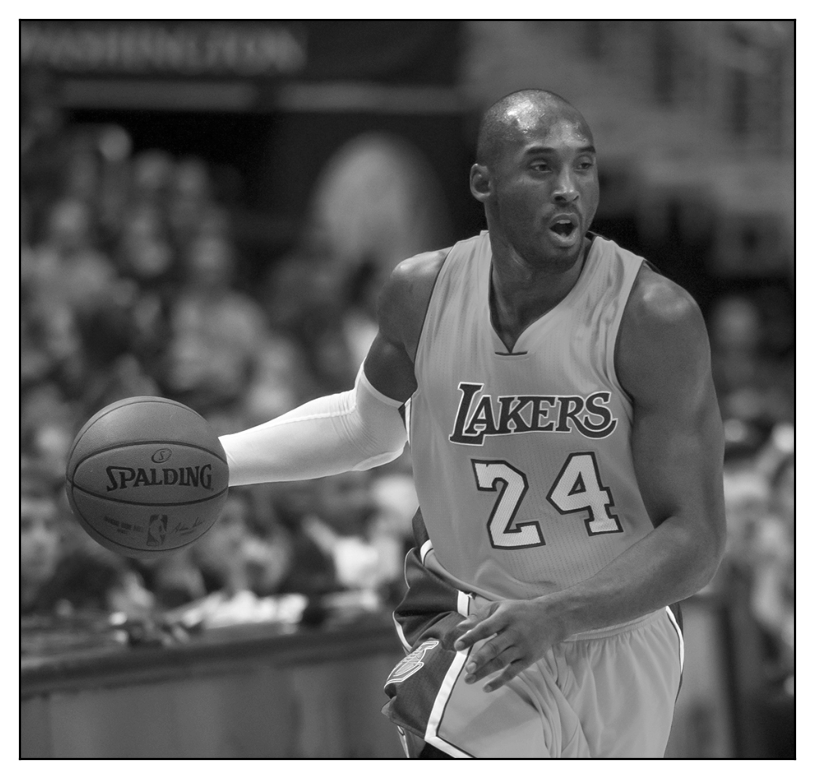

In [6]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
image = imageio.v2.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

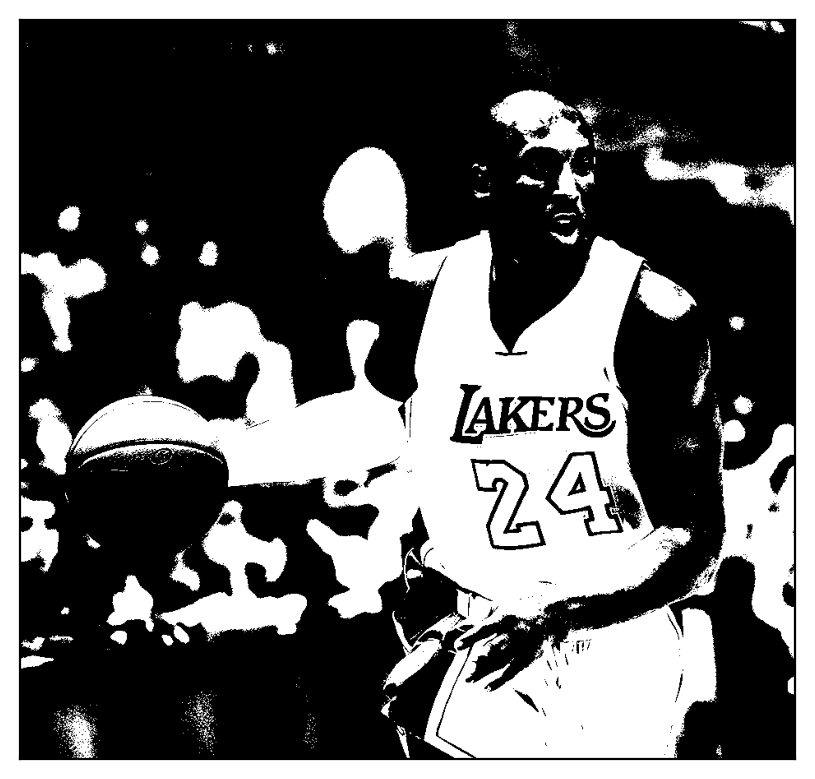

In [7]:
def segment(image, threshold=100):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image))

In [27]:
%%cython
import numpy as np
import cython 

# if you comment this decorator, cython will warn you to add it for faster access
@cython.boundscheck(False) 
cdef int _segment(double[:,:] image, int n, int m,
                  double threshold, double[:,:] output) nogil: 
    # note the "nogil" directive
    # note the int return type (rather than void) that allows cython to return error code instead of checking for exceptions
    cdef int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def csegment(image, threshold=100):
    output = np.zeros_like(image)
    n, m = image.shape
    _segment(image, n , m, threshold, output)
    return output

Content of stderr:
/Users/yoavram/.cache/ipython/cython/_cython_magic_d0cdedbf94fda636f06058c565f00739ca6f7d1e.c:21524:13: warning: code will never be executed [-Wunreachable-code]
 21524 |             goto bad;
       |             ^~~~~~~~
/Users/yoavram/.cache/ipython/cython/_cython_magic_d0cdedbf94fda636f06058c565f00739ca6f7d1e.c:22203:26: warning: code will never be executed [-Wunreachable-code]
 22203 |                 module = PyImport_ImportModuleLevelObject(
       |                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 warnings generated.

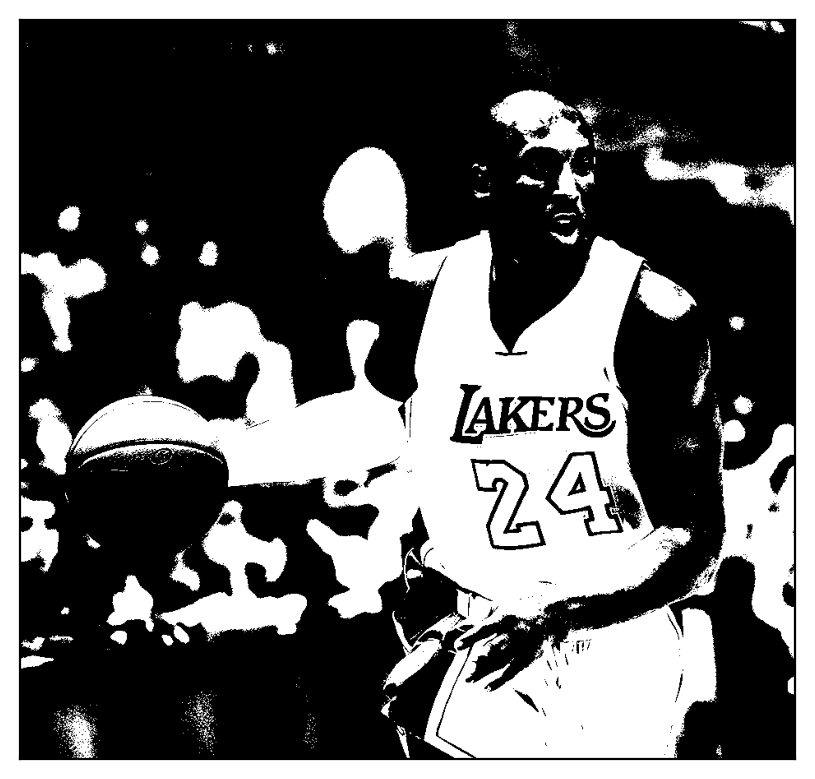

In [12]:
display_image(csegment(image))

In [13]:
%timeit segment(image)
%timeit csegment(image)

2.34 ms ± 325 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.27 ms ± 16.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So on a single image Cython is 2-fold faster. 
What about using multi-threading for segmenting a bunch of images?

Let's download the 30 examples images from the [Berkeley Segmentation Dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/test-001-025.html).

![example](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg)

In [14]:
image_urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/{:d}.jpg'.format(i)
    for i in [119082,170057,58060,163085,42049,167062,157055,295087,24077,78004,220075,45096,38092,43074,16077,86000,101085,219090,89072,300091,126007,156065,76053,296007,175032]
]
image_urls[0]

'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/119082.jpg'

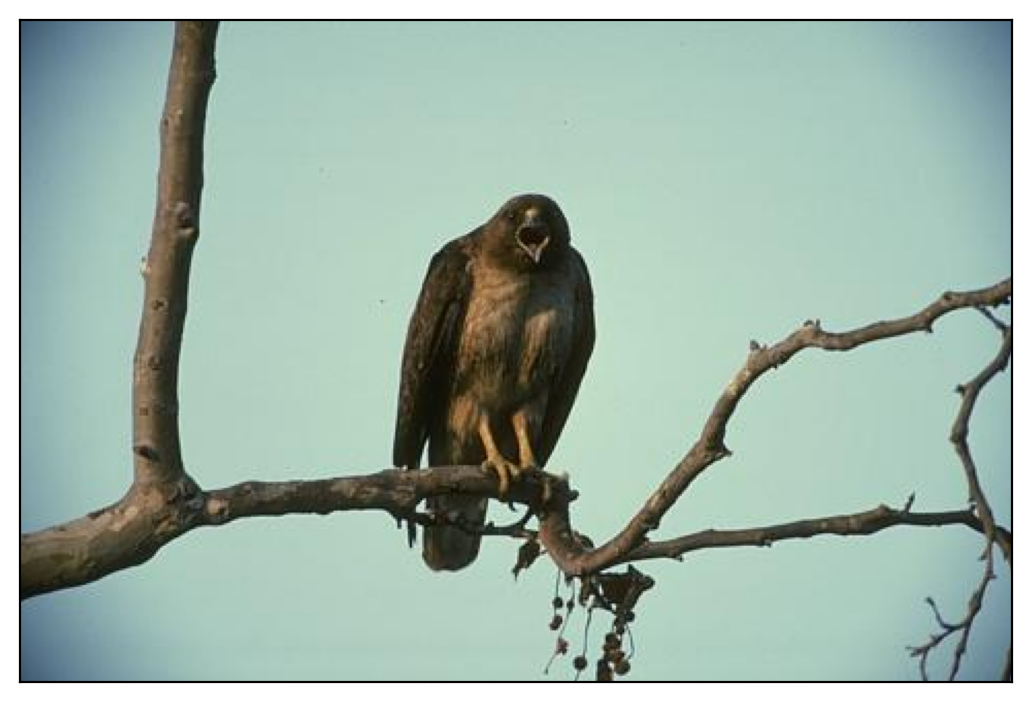

In [16]:
display_image(imageio.v2.imread(image_urls[4]))

Let's load and flatten the images:

In [17]:
images = [imageio.v2.imread(url) for url in image_urls] # load
images = [im.mean(axis=2) for im in images] # flatten to bnw

Let's also resize the images so that the segmentation task is computationaly harder.

In [18]:
shapes = [im.shape for im in images]
images = [resize(im, (w*12, h*12), mode='reflect') 
          for im, (w, h) in zip(images, shapes)]

First compare the NumPy and Cython versions:

In [19]:
%timeit -n 1 -r 1 [segment(im) for im in images]
%timeit -n 1 -r 1 [csegment(im) for im in images]

4.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


A nice improvement on a single thread.
Now let's do it with multi-threading, leveraging the `nogil` directive.

In [20]:
from concurrent.futures import ThreadPoolExecutor

def psegment(images):   
    with ThreadPoolExecutor() as executor:
        results = executor.map(csegment, images)
        return list(results)

In [22]:
%timeit psegment(images)

1.17 s ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So the parallel version actually runs about 3.5 faster!

You can look at the process monitor (or `top`/`htop` on Linux/Mac) when the next two cells run to see that the first uses less cores than the latter. 

In [23]:
for _ in range(10): 
    [csegment(im) for im in images];

In [26]:
for _ in range(10): 
    psegment(images);

# References

- [Cython language basics](http://docs.cython.org/src/userguide/language_basics.html#language-basics)
- [Cython for NumPy users](http://docs.cython.org/src/userguide/numpy_tutorial.html#numpy-tutorial) offers a 2D convolve example.
- [IPython Cookbook](https://ipython-books.github.io/cookbook/) by Cyrille Rossant has a full chapter on high performance computing. with many [notebook examples](https://github.com/ipython-books/cookbook-code/tree/master/notebooks/chapter05_hpc) and a more complicated Cython example.
- Jake Vanderplas's [Cython project template](https://github.com/jakevdp/cython_template) can help you build projects that use Cython.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com). 

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)